In [1]:
# to avoid to restart kernel when external modules are modified
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import pickle as pkl

import cv2
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from music21 import instrument, note, stream, chord, duration

sys.path.append("../.")

from image_to_melody.img_utils import (
    get_k_representatives, get_representative_pixels
)
from image_to_melody.utils import map_value_to_dest
from experiments.exp_3.lstm_model import create_network, sample_with_temp

2023-05-24 21:11:54.254423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Generate set of unique notes

In [3]:
ARTIFACTS_FOLDER = "exp_3/artifacts/"

with open(os.path.join(ARTIFACTS_FOLDER, "distincts.pkl"), "rb") as filepath:
    distincts = pkl.load(filepath)
    note_names, n_notes, duration_names, n_durations = distincts

with open(os.path.join(ARTIFACTS_FOLDER, "lookups.pkl"), "rb") as filepath:
    lookups = pkl.load(filepath)
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups

In [14]:
single_notes_set = set()

for chord, int_val in note_to_int.items():
    single_notes_set.add(chord.split(".")[0])

In [25]:
#single_notes_set.remove("START")

single_notes_set = list(single_notes_set)
single_notes_set.sort(reverse=True)
single_notes_set

['G5',
 'G4',
 'G3',
 'G2',
 'G#4',
 'G#3',
 'G#2',
 'F4',
 'F3',
 'F2',
 'F#5',
 'F#4',
 'F#3',
 'F#2',
 'E5',
 'E4',
 'E3',
 'E2',
 'E-5',
 'E-4',
 'E-3',
 'E-2',
 'D5',
 'D4',
 'D3',
 'D2',
 'C5',
 'C4',
 'C3',
 'C2',
 'C#5',
 'C#4',
 'C#3',
 'C#2',
 'B4',
 'B3',
 'B2',
 'B-4',
 'B-3',
 'B-2',
 'A4',
 'A3',
 'A2']

In [26]:
with open(os.path.join(ARTIFACTS_FOLDER, "single_notes_set.txt"), "w") as f:
    f.write(str(single_notes_set))

In [4]:
import ast

with open(os.path.join(ARTIFACTS_FOLDER, "single_notes_set.txt"), "r") as f:
    single_notes_loaded = ast.literal_eval(f.read())

single_notes_loaded

['G5',
 'G4',
 'G3',
 'G2',
 'G#4',
 'G#3',
 'G#2',
 'F4',
 'F3',
 'F2',
 'F#5',
 'F#4',
 'F#3',
 'F#2',
 'E5',
 'E4',
 'E3',
 'E2',
 'E-5',
 'E-4',
 'E-3',
 'E-2',
 'D5',
 'D4',
 'D3',
 'D2',
 'C5',
 'C4',
 'C3',
 'C2',
 'C#5',
 'C#4',
 'C#3',
 'C#2',
 'B4',
 'B3',
 'B2',
 'B-4',
 'B-3',
 'B-2',
 'A4',
 'A3',
 'A2']

### Read image and get the representative pixels

In [43]:
base_path = "../sample_images"
sample_img_filename = "003_starry_night.jpg"

In [ ]:
img = cv2.imread(filename=f"{base_path}/{sample_img_filename}")
hsv_img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2HSV)

plt.imshow(hsv_img)
plt.show()

In [45]:
number_slices = 5
k = 5

representative_pixels = get_representative_pixels(
    hsv_img, number_slices, k
)

In [46]:
num_pixels = number_slices * k

# df_repixels = pd.DataFrame(
#     representative_pixels[:num_pixels], columns=["red", "green", "blue"]
# )
df_repixels = pd.DataFrame(
    representative_pixels, columns=["hue", "saturation", "value"]
)
df_repixels.shape

(25, 3)

In [47]:
"""In OpenCV, the range of values are:

HUE: 0-180
SATURATION: 0-255
VALUE: 0-255
"""

df_repixels.describe()

,hue,saturation,value
count,25.000000,25.000000,25.000000
mean,88.365508,109.440870,110.246827
std,25.119351,53.579457,51.272999
min,26.309732,42.420871,36.017928
25%,82.229142,60.954845,58.299289
50%,95.322672,106.677301,125.419446
75%,106.475683,157.782007,155.211060
max,109.814520,190.478810,178.493077


array([[<Axes: title={'center': 'hue'}>,
        <Axes: title={'center': 'saturation'}>],
       [<Axes: title={'center': 'value'}>, <Axes: >]], dtype=object)

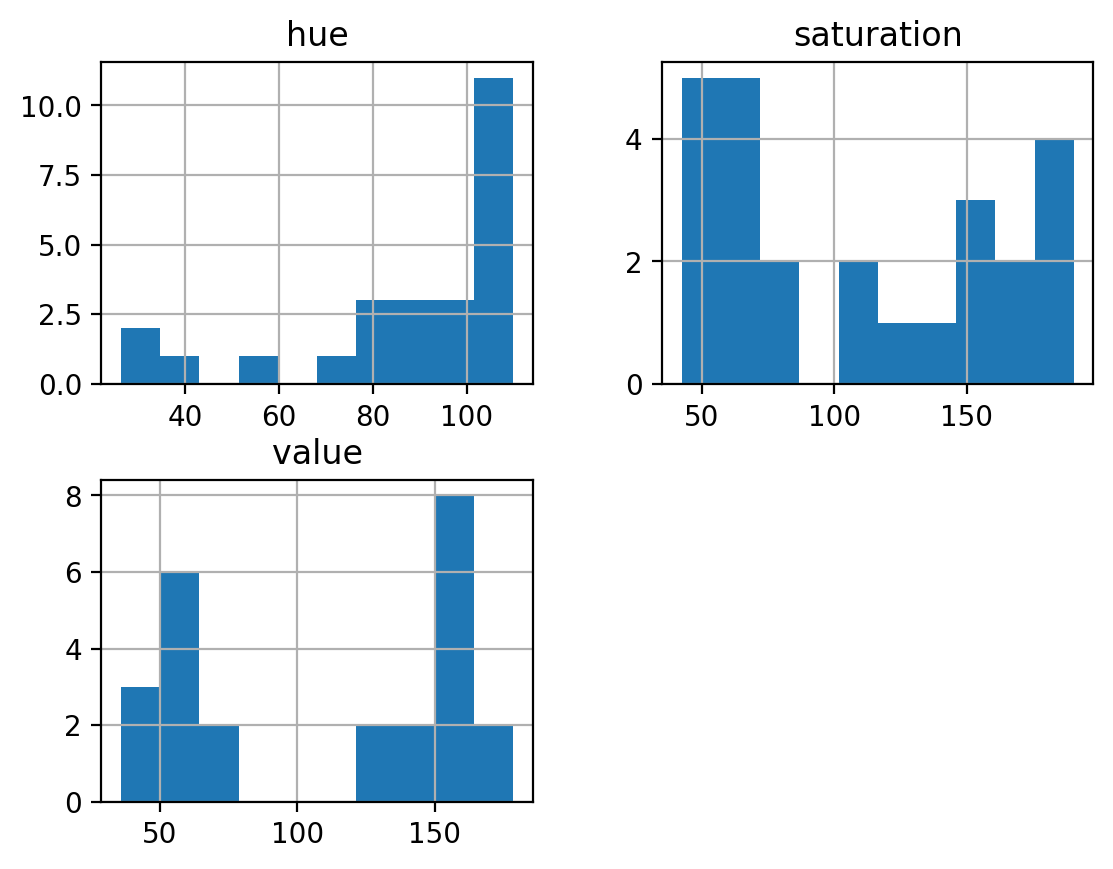

In [48]:
df_repixels[["hue", "saturation", "value"]].hist()

### Mapping - Hue values to notes in a linear way

In [49]:
HUE_MAX_VAL = 180
# single_notes_loaded
thresholds = np.linspace(start=0, stop=HUE_MAX_VAL, num=len(single_notes_loaded))

df_repixels["notes"] = df_repixels.apply(
    lambda row : map_value_to_dest(row["hue"], single_notes_loaded, thresholds=thresholds), axis=1
)

df_repixels.head()

,hue,saturation,value,notes
0,69.970194,60.954845,49.392000,E2
1,42.729540,51.918248,156.932091,F#5
2,103.862090,75.514713,158.836920,D2
3,97.505974,171.629707,60.507450,D4
4,108.179773,150.409337,137.656489,C5


In [50]:
df_repixels["notes"].describe(include="all")

count     25
unique    11
top       C5
freq       6
Name: notes, dtype: object

<Axes: >

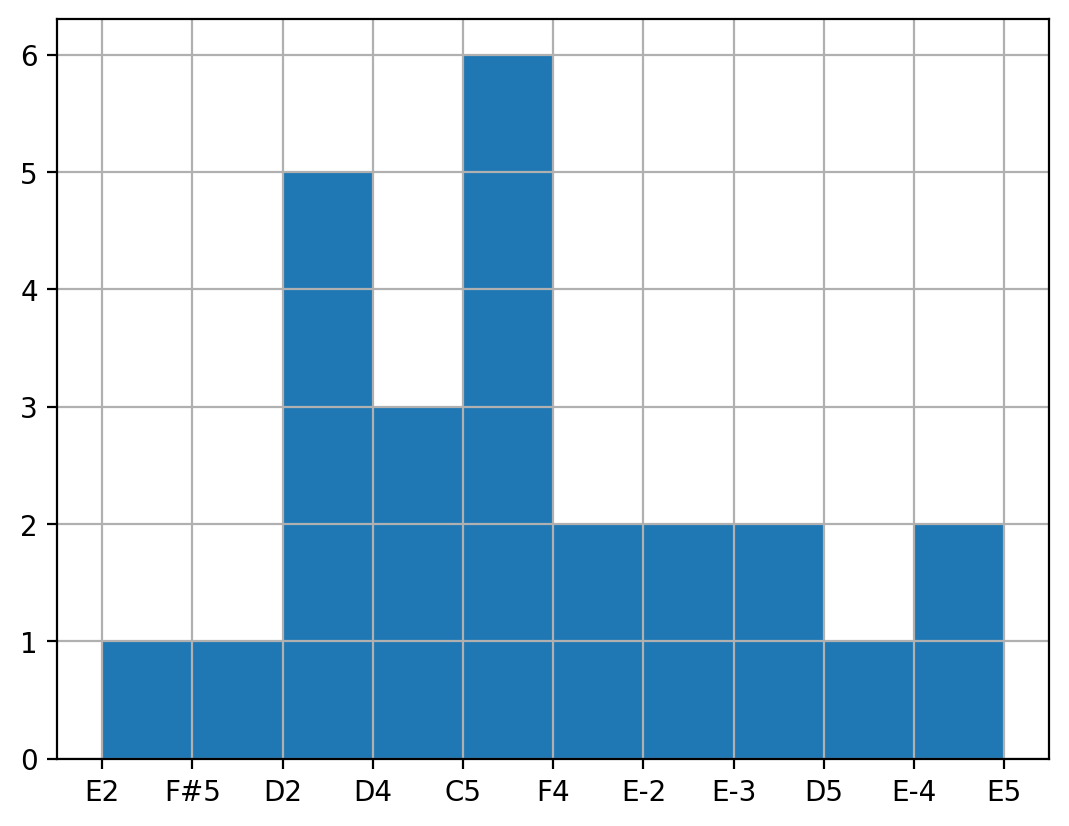

In [51]:
df_repixels["notes"].hist()

### Generate 25 notes using the LSTModel

In [52]:
weights_filepath = os.path.join(ARTIFACTS_FOLDER, "weights.h5")
use_attention = True
embedding_size = 100
rnn_units = 256

model, att_model = create_network(
    n_notes, n_durations, embedding_size, rnn_units, use_attention
)

# Load the weights to each node
model.load_weights(weights_filepath)
model.summary()


2023-05-24 21:43:55.477282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-24 21:43:55.480411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-24 21:43:55.483283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 100)    47000       ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, None, 100)    1700        ['input_6[0][0]']                
                                                                                            

In [53]:
# prediction params
notes_temp = 0.5
duration_temp = 0.5
max_extra_notes = 50
max_seq_len = 25
seq_len = 25

notes = list()
durations = list()

for idx, row in df_repixels.iterrows():
    notes.append(row["notes"])
    durations.append(1)

notes[0] = "START"
durations[0] = 0

sequence_lenght = len(notes)

notes, sequence_lenght

(['START',
  'F#5',
  'D2',
  'D4',
  'C5',
  'F4',
  'E-2',
  'E-3',
  'D5',
  'D2',
  'E-3',
  'E-2',
  'D2',
  'D2',
  'C5',
  'D4',
  'E-4',
  'C5',
  'D2',
  'C5',
  'D4',
  'E5',
  'C5',
  'C5',
  'F4'],
 25)

In [54]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []

overall_preds = []

for n, d in zip(notes, durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]
    
    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)
    
    #prediction_output.append([n, d])
    
    if n != "START":
        midi_note = note.Note(n)

        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        #overall_preds.append(new_note)


for note_index in range(max_extra_notes):
    prediction_input = [
        np.array([notes_input_sequence]), np.array([durations_input_sequence])
    ]

    notes_prediction, durations_prediction = model.predict(prediction_input, verbose=0)
    
    new_note = np.zeros(128)
    
    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i
        except:
            pass
        
    overall_preds.append(new_note)
    
    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]
    
    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)
    
    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]
        
    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds)) 
print('Generated sequence of {} notes'.format(len(prediction_output)))

2023-05-24 21:43:59.042630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-24 21:43:59.046158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-24 21:43:59.049278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Generated sequence of 50 notes


In [55]:
prediction_output

[['G4', 1.0],
 ['A4', 1.0],
 ['B-3', 1.0],
 ['B-3', 1.0],
 ['G3', 1.0],
 ['B-3', 1.0],
 ['B-3', 1.0],
 ['E-3', 1.0],
 ['D3.A3', 1.0],
 ['F2', 1.0],
 ['E-3', 1.0],
 ['E4', 1.0],
 ['G#3', 1.0],
 ['B-3', 1.0],
 ['C#4', 1.0],
 ['G3', 1.0],
 ['F#3', 1.0],
 ['G#3', 1.0],
 ['E4', 1.0],
 ['B3', 1.0],
 ['B3', 1.0],
 ['B3', 1.0],
 ['B3', 1.0],
 ['A3', 1.0],
 ['A4', 1.0],
 ['G3', 1.0],
 ['G3', 1.0],
 ['G3', 0.5],
 ['G#3', 0.5],
 ['G3', 0.5],
 ['G#3', 1.0],
 ['B-3', 1.0],
 ['G3', 0.5],
 ['G3', 0.5],
 ['E-3', 1.0],
 ['G3', 1.0],
 ['G#3', 1.0],
 ['E-3', 0.5],
 ['C#3', 1.0],
 ['G3', 1.0],
 ['A3.B3', 1.0],
 ['A3', 1.0],
 ['C#3', 0.5],
 ['G3', 1.0],
 ['G3', 1.0],
 ['G3', 0.5],
 ['C#3', 0.5],
 ['G3', 0.5],
 ['E-3', 1.0],
 ['E-3', 1.0]]

#### Generate MIDI FILE

In [56]:
import time

output_midi_file = f"melody-{time.strftime('%Y%m%d-%H:%M:%S')}.mid"
output_midi_file = os.path.join("tmp", output_midi_file)
output_midi_file

midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)

midi_stream.write("midi", fp=output_midi_file)

'tmp/melody-20230524-21:44:08.mid'

### Sinthesize

In [57]:
from midi2audio import FluidSynth

SAMPLE_RATE = 44100
# Replace this with the path to your SoundFont file
soundfont_path = (
    "/home/david/Descargas/GeneralUser_GS_1.471/GeneralUser GS 1.471/GeneralUser GS v1.471.sf2"
)

def synthesize(midi_file_path: str, output_path: str, sample_rate: int):
    fs = FluidSynth(sound_font=soundfont_path, sample_rate=sample_rate)

    fs.midi_to_audio(midi_file_path, output_path)

In [ ]:
output_filepath = output_midi_file.replace("mid", "mp3")

synthesize(
    output_midi_file, output_filepath, sample_rate=SAMPLE_RATE
)

ipd.Audio(data=output_filepath, rate=SAMPLE_RATE, autoplay=True)